# Data Analytics for Health - Task 2.2: Density-Based Clustering Analysis

## Overview
This notebook performs density-based clustering (DBSCAN) analysis on the prepared patient profile:
- 2.2.1: Study of the clustering parameters (eps and min_samples)
- 2.2.2: Characterization and interpretation of the obtained clusters

## Objectives
- Determine optimal DBSCAN parameters (eps and min_samples)
- Analyze cluster characteristics and identify noise points
- Interpret the density-based clustering results

---


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data
Plots directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/plots


## 1. Load Prepared Patient Profile


In [2]:
# Load prepared patient profile
df = pd.read_csv(data_path / '1.2.2_prepared_patient_profile.csv')

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")

# Prepare data for clustering
X = df[numeric_features].copy()
subject_ids = df['subject_id'].copy()

# Handle any remaining NaN values
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")


Loaded patient profile: 4,392 subjects × 14 features

Numeric features for clustering: 12

NaN values before handling: 4001
NaN values after handling: 0

Data prepared for clustering: (4392, 12)


## 2.2.1 Study of the Clustering Parameters

### K-distance Graph for eps Selection


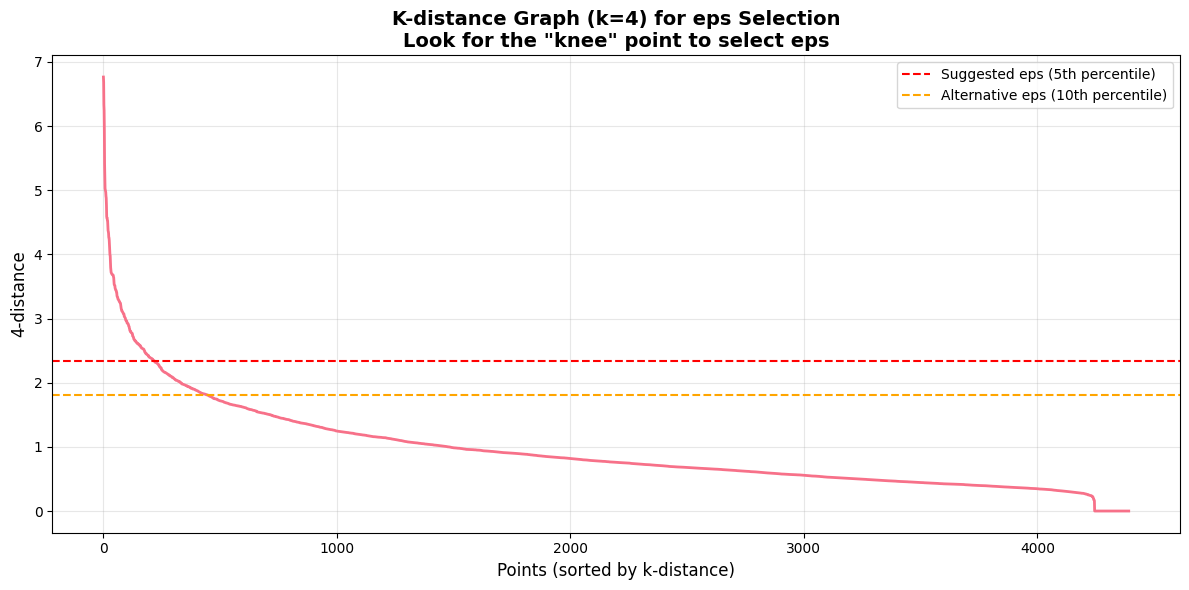

Suggested eps (5th percentile): 2.3367
Alternative eps (10th percentile): 1.8155


In [3]:
# Compute k-distances to help select eps parameter
# Use k = min_samples (typically 4 or 5 for DBSCAN)
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Get k-th nearest neighbor distances (k-distance)
k_distances = distances[:, k-1]
k_distances_sorted = np.sort(k_distances)[::-1]  # Sort in descending order

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2)
plt.xlabel('Points (sorted by k-distance)', fontsize=12)
plt.ylabel(f'{k}-distance', fontsize=12)
plt.title(f'K-distance Graph (k={k}) for eps Selection\nLook for the "knee" point to select eps', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=k_distances_sorted[int(len(k_distances_sorted) * 0.05)], 
           color='r', linestyle='--', label='Suggested eps (5th percentile)')
plt.axhline(y=k_distances_sorted[int(len(k_distances_sorted) * 0.1)], 
           color='orange', linestyle='--', label='Alternative eps (10th percentile)')
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / '2.2.1_k_distance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

suggested_eps = k_distances_sorted[int(len(k_distances_sorted) * 0.05)]
alt_eps = k_distances_sorted[int(len(k_distances_sorted) * 0.1)]
print(f"Suggested eps (5th percentile): {suggested_eps:.4f}")
print(f"Alternative eps (10th percentile): {alt_eps:.4f}")


### Parameter Grid Search: Testing Different eps and min_samples Values


In [4]:
# Test different combinations of eps and min_samples
eps_values = np.linspace(0.5, 3.0, 10)  # Adjust range based on k-distance graph
min_samples_values = [3, 4, 5, 6, 7]

param_results = []

print("Testing different parameter combinations...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Compute metrics only if we have at least 2 clusters
        if n_clusters >= 2:
            # Filter out noise points for metric computation
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 1:
                silhouette = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                davies_bouldin = davies_bouldin_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                calinski_harabasz = calinski_harabasz_score(X_scaled[non_noise_mask], labels[non_noise_mask])
            else:
                silhouette = -1
                davies_bouldin = np.inf
                calinski_harabasz = 0
        else:
            silhouette = -1
            davies_bouldin = np.inf
            calinski_harabasz = 0
        
        param_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz
        })
        
        print(f"eps={eps:.2f}, min_samples={min_samples}: "
              f"{n_clusters} clusters, {n_noise} noise ({noise_ratio:.1%}), "
              f"Silhouette={silhouette:.3f}")

param_df = pd.DataFrame(param_results)


Testing different parameter combinations...
eps=0.50, min_samples=3: 47 clusters, 2826 noise (64.3%), Silhouette=-0.243
eps=0.50, min_samples=4: 19 clusters, 2989 noise (68.1%), Silhouette=-0.187
eps=0.50, min_samples=5: 9 clusters, 3083 noise (70.2%), Silhouette=-0.118
eps=0.50, min_samples=6: 10 clusters, 3151 noise (71.7%), Silhouette=-0.150
eps=0.50, min_samples=7: 6 clusters, 3227 noise (73.5%), Silhouette=-0.089
eps=0.78, min_samples=3: 34 clusters, 1695 noise (38.6%), Silhouette=-0.178
eps=0.78, min_samples=4: 16 clusters, 1831 noise (41.7%), Silhouette=-0.095
eps=0.78, min_samples=5: 8 clusters, 1929 noise (43.9%), Silhouette=0.049
eps=0.78, min_samples=6: 3 clusters, 2021 noise (46.0%), Silhouette=0.136
eps=0.78, min_samples=7: 4 clusters, 2072 noise (47.2%), Silhouette=0.088
eps=1.06, min_samples=3: 24 clusters, 1043 noise (23.7%), Silhouette=0.041
eps=1.06, min_samples=4: 13 clusters, 1120 noise (25.5%), Silhouette=0.073
eps=1.06, min_samples=5: 7 clusters, 1191 noise (27.1%

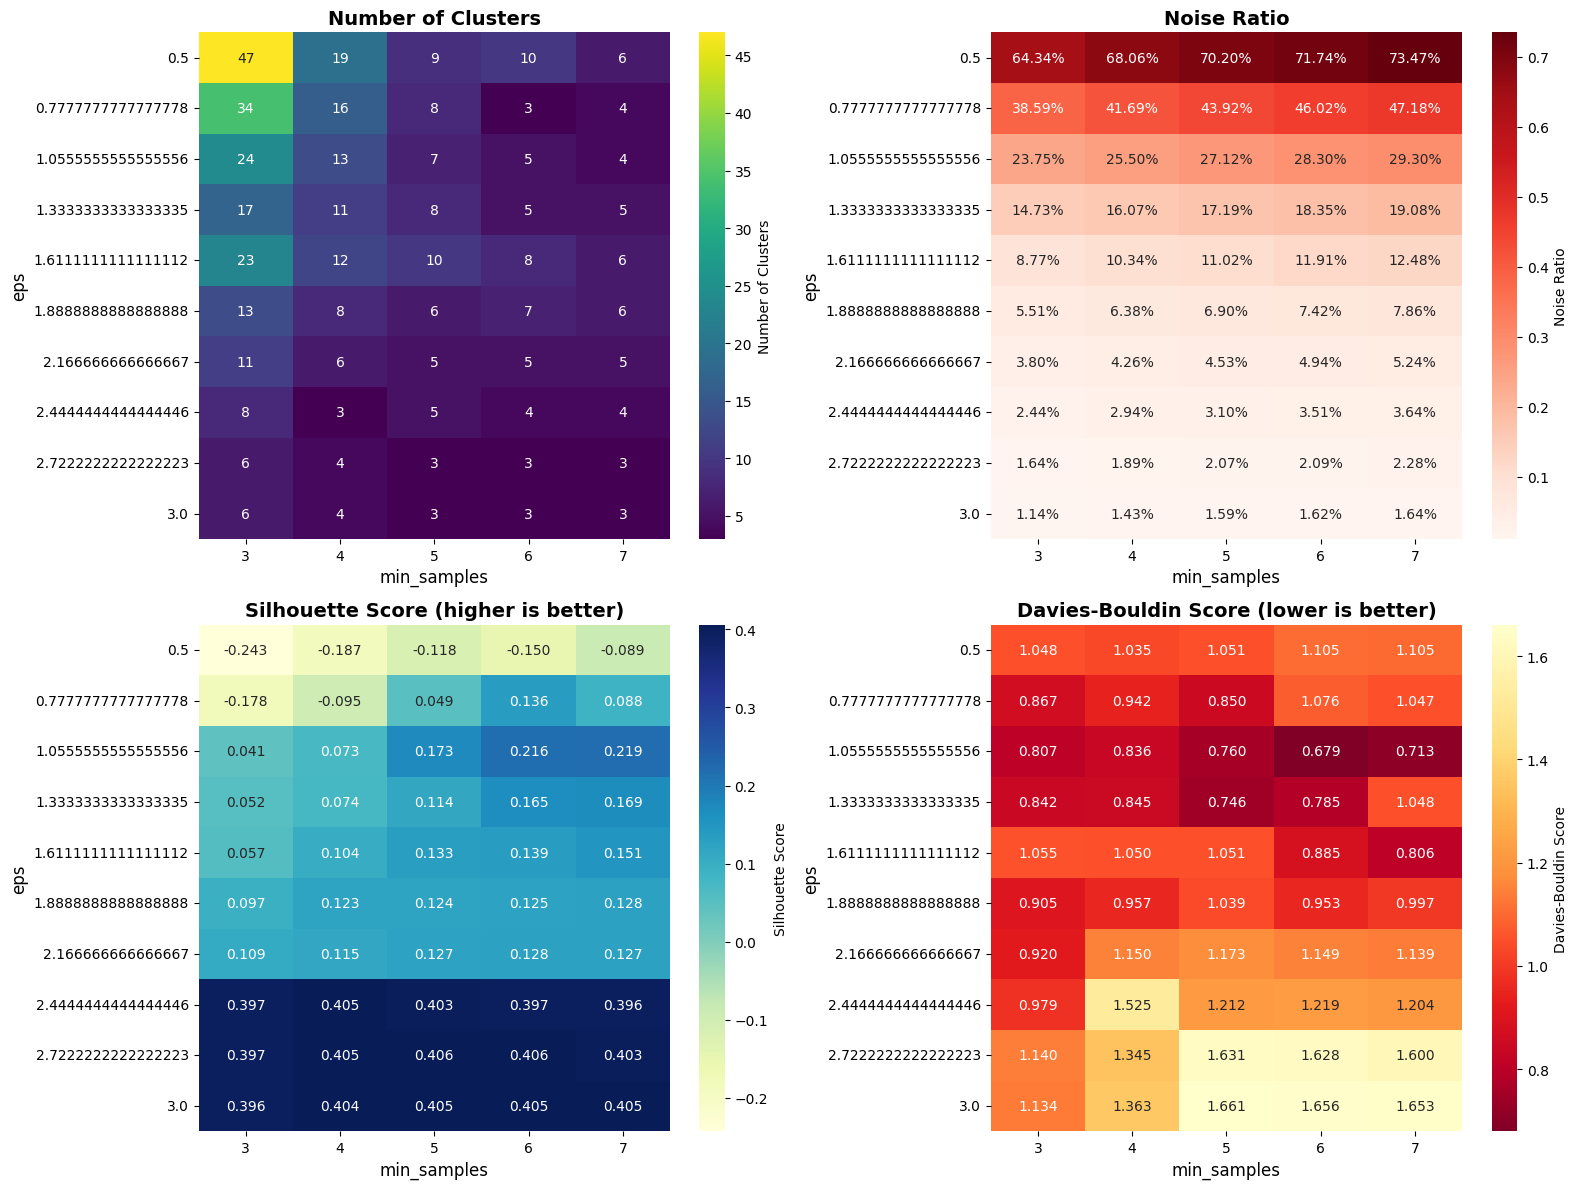

In [5]:
# Visualize parameter search results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Number of clusters
pivot_clusters = param_df.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='viridis', ax=axes[0, 0], cbar_kws={'label': 'Number of Clusters'})
axes[0, 0].set_title('Number of Clusters', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('min_samples', fontsize=12)
axes[0, 0].set_ylabel('eps', fontsize=12)

# Noise ratio
pivot_noise = param_df.pivot(index='eps', columns='min_samples', values='noise_ratio')
sns.heatmap(pivot_noise, annot=True, fmt='.2%', cmap='Reds', ax=axes[0, 1], cbar_kws={'label': 'Noise Ratio'})
axes[0, 1].set_title('Noise Ratio', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('min_samples', fontsize=12)
axes[0, 1].set_ylabel('eps', fontsize=12)

# Silhouette score (only valid clusters)
pivot_sil = param_df.pivot(index='eps', columns='min_samples', values='silhouette')
pivot_sil = pivot_sil.replace(-1, np.nan)  # Replace invalid values
sns.heatmap(pivot_sil, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 0], 
           cbar_kws={'label': 'Silhouette Score'}, mask=pivot_sil.isna())
axes[1, 0].set_title('Silhouette Score (higher is better)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('min_samples', fontsize=12)
axes[1, 0].set_ylabel('eps', fontsize=12)

# Davies-Bouldin score
pivot_db = param_df.pivot(index='eps', columns='min_samples', values='davies_bouldin')
pivot_db = pivot_db.replace(np.inf, np.nan)
sns.heatmap(pivot_db, annot=True, fmt='.3f', cmap='YlOrRd_r', ax=axes[1, 1], 
           cbar_kws={'label': 'Davies-Bouldin Score'}, mask=pivot_db.isna())
axes[1, 1].set_title('Davies-Bouldin Score (lower is better)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('min_samples', fontsize=12)
axes[1, 1].set_ylabel('eps', fontsize=12)

plt.tight_layout()
plt.savefig(plots_dir / '2.2.1_parameter_search.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Find best parameters (balance between clusters, noise, and quality)
# Filter valid results (at least 2 clusters, reasonable noise ratio)
valid_results = param_df[(param_df['n_clusters'] >= 2) & (param_df['noise_ratio'] < 0.5)]

if len(valid_results) > 0:
    # Score based on silhouette (higher better) and noise ratio (lower better)
    valid_results['score'] = (valid_results['silhouette'] + 1) / 2 - valid_results['noise_ratio']
    best_params = valid_results.loc[valid_results['score'].idxmax()]
    
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
    
    print("="*80)
    print("OPTIMAL PARAMETERS")
    print("="*80)
    print(f"eps: {optimal_eps:.2f}")
    print(f"min_samples: {optimal_min_samples}")
    print(f"\nExpected results:")
    print(f"  Number of clusters: {int(best_params['n_clusters'])}")
    print(f"  Noise points: {int(best_params['n_noise'])} ({best_params['noise_ratio']:.1%})")
    print(f"  Silhouette score: {best_params['silhouette']:.3f}")
else:
    # Fallback: use suggested eps from k-distance graph
    optimal_eps = suggested_eps
    optimal_min_samples = 4
    print(f"Using default parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")


OPTIMAL PARAMETERS
eps: 3.00
min_samples: 4

Expected results:
  Number of clusters: 4
  Noise points: 63 (1.4%)
  Silhouette score: 0.404


## 2.2.2 Characterization and Interpretation of the Obtained Clusters

### Perform Final DBSCAN Clustering


In [7]:
# Perform DBSCAN clustering with optimal parameters
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = dbscan_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

# Analyze results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
noise_ratio = n_noise / len(cluster_labels)

print("="*80)
print("DBSCAN CLUSTERING RESULTS")
print("="*80)
print(f"Parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({noise_ratio:.1%})")
print(f"\nCluster distribution:")
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print(cluster_counts)

# Save clustered data
df_clustered.to_csv(data_path / '2.2_dbscan_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.2_dbscan_clustered_data.csv'}")


DBSCAN CLUSTERING RESULTS
Parameters: eps=3.00, min_samples=4
Number of clusters: 4
Noise points: 63 (1.4%)

Cluster distribution:
cluster
-1      63
 0     289
 1    3987
 2      49
 3       4
Name: count, dtype: int64

Clustered data saved to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/2.2_dbscan_clustered_data.csv


### Cluster Characteristics Analysis


Cluster Characteristics (Mean Values):
   cluster  size  n_lab_events  n_micro_exam  total_procedures  n_diagnoses  \
0        0   289          0.70          0.30              0.56         2.26   
1        1  3987         -0.11         -0.05             -0.07        -0.26   
2        2    49          1.41          0.37              0.78         4.72   
3        3     4          0.88         -0.25              1.66         2.29   

   n_positive_micro  abnormal_ratio  max_glucose  mean_creatinine  \
0               0.0            0.26         0.13             0.02   
1               0.0           -0.03        -0.05            -0.02   
2               0.0            0.51         0.37             0.05   
3               0.0            0.13         0.62            -0.28   

   mean_hemoglobin   age  days_since_last_admission_x  n_total_admissions  
0            -0.16  0.07                        -0.16                2.54  
1             0.02  0.00                          NaN              

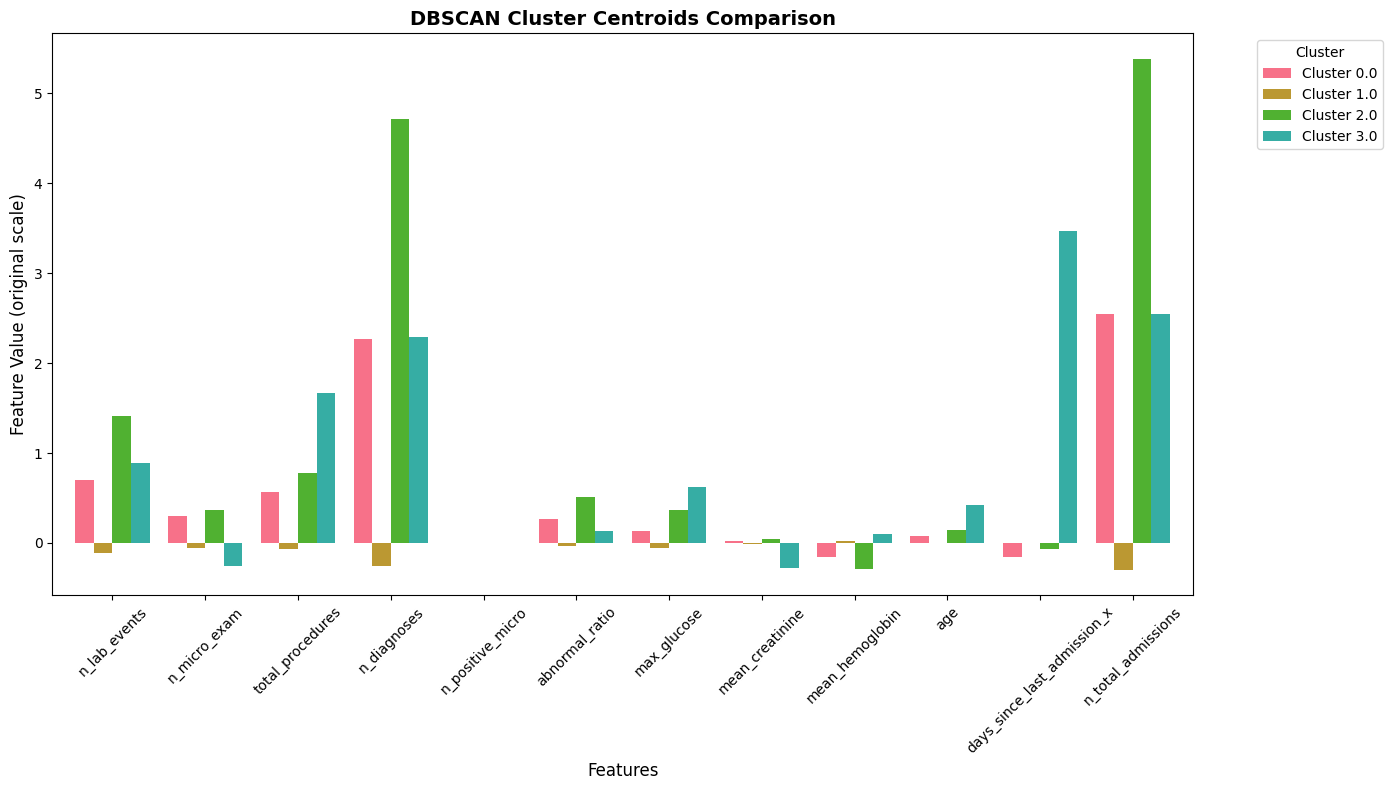

In [8]:
# Analyze cluster characteristics (excluding noise points)
valid_clusters = df_clustered[df_clustered['cluster'] != -1]

if len(valid_clusters) > 0:
    # Compute cluster statistics
    cluster_stats = []
    for cluster_id in sorted(valid_clusters['cluster'].unique()):
        cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id]
        
        stats = {'cluster': cluster_id, 'size': len(cluster_data)}
        for feature in numeric_features:
            stats[f'{feature}_mean'] = cluster_data[feature].mean()
            stats[f'{feature}_std'] = cluster_data[feature].std()
        
        cluster_stats.append(stats)
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Display mean values for each cluster
    print("Cluster Characteristics (Mean Values):")
    mean_cols = [col for col in cluster_stats_df.columns if col.endswith('_mean')]
    display_df = cluster_stats_df[['cluster', 'size'] + mean_cols].copy()
    display_df.columns = ['cluster', 'size'] + [col.replace('_mean', '') for col in mean_cols]
    print(display_df.round(2))
    
    # Visualize cluster centroids comparison
    centroid_data = []
    for cluster_id in sorted(valid_clusters['cluster'].unique()):
        cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id]
        centroid = cluster_data[numeric_features].mean()
        centroid['cluster'] = cluster_id
        centroid_data.append(centroid)
    
    centroids_df = pd.DataFrame(centroid_data)
    centroids_df = centroids_df.set_index('cluster')
    centroids_df.index = [f'Cluster {i}' for i in centroids_df.index]
    
    # Plot centroids
    fig, ax = plt.subplots(figsize=(14, 8))
    centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Value (original scale)', fontsize=12)
    ax.set_title('DBSCAN Cluster Centroids Comparison', fontsize=14, fontweight='bold')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(plots_dir / '2.2.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No valid clusters found (all points are noise). Try adjusting parameters.")


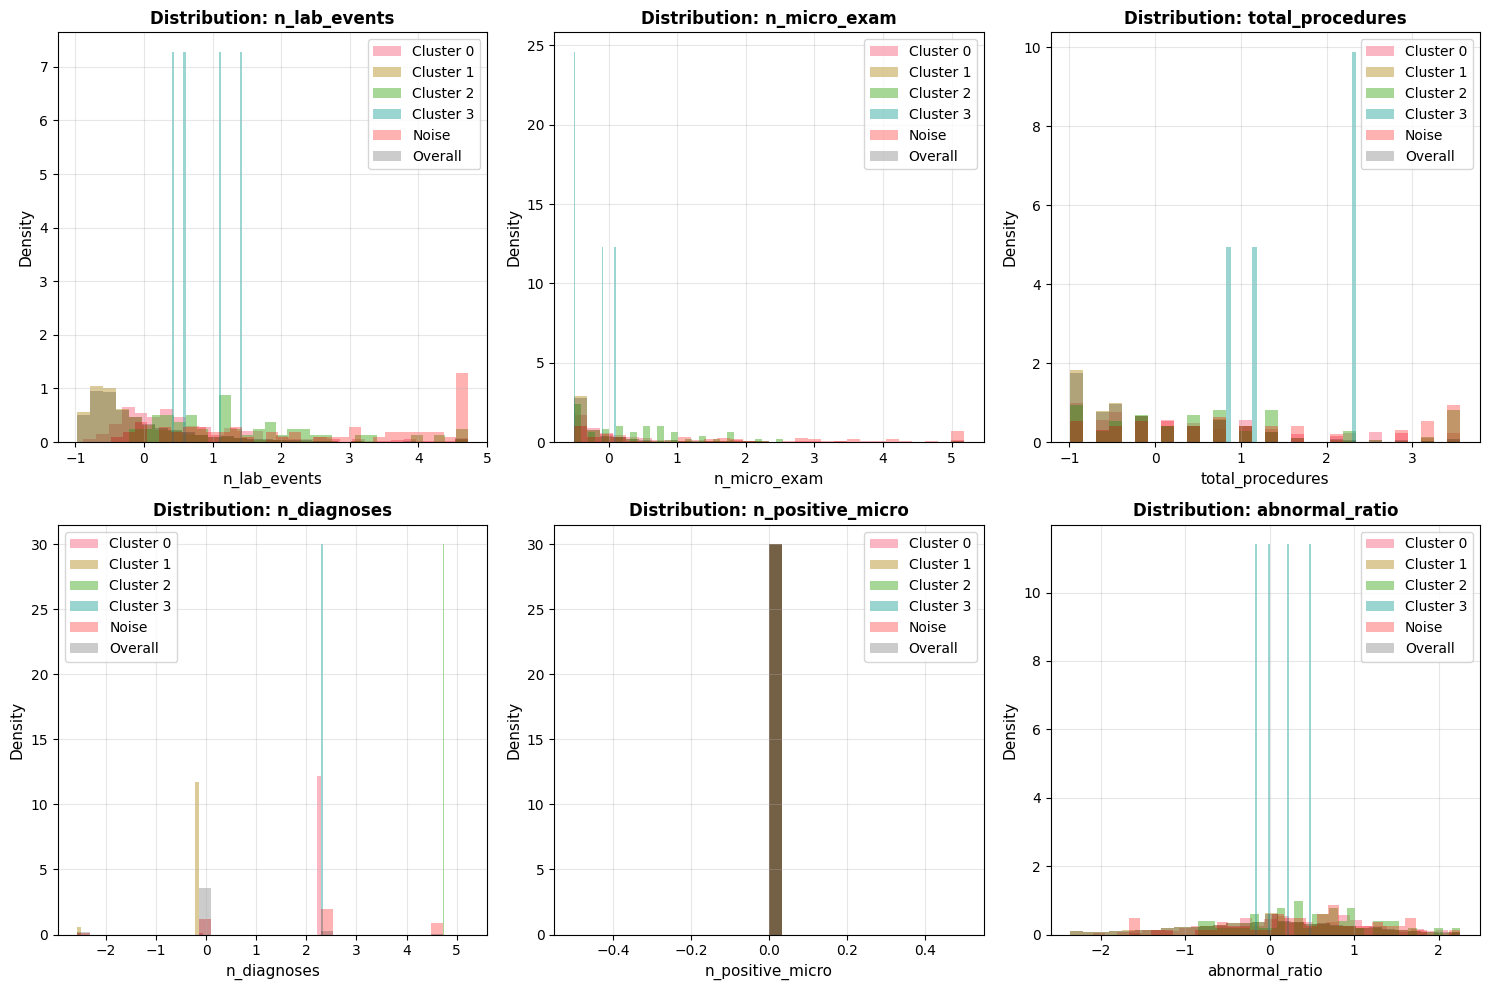

In [9]:
# Compare distributions: clusters vs overall vs noise
if len(valid_clusters) > 0:
    key_features = numeric_features[:6]  # Select first 6 features
    
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(key_features):
        ax = axes[idx]
        
        # Plot distribution for each cluster
        for cluster_id in sorted(valid_clusters['cluster'].unique()):
            cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id][feature]
            ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
        
        # Plot noise points
        if n_noise > 0:
            noise_data = df_clustered[df_clustered['cluster'] == -1][feature]
            ax.hist(noise_data, alpha=0.3, color='red', label='Noise', bins=30, density=True, 
                   linestyle=':', linewidth=2)
        
        # Plot overall distribution
        ax.hist(df_clustered[feature], alpha=0.2, color='black', 
               label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
        
        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(plots_dir / '2.2.2_feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


### 2D Visualization using PCA


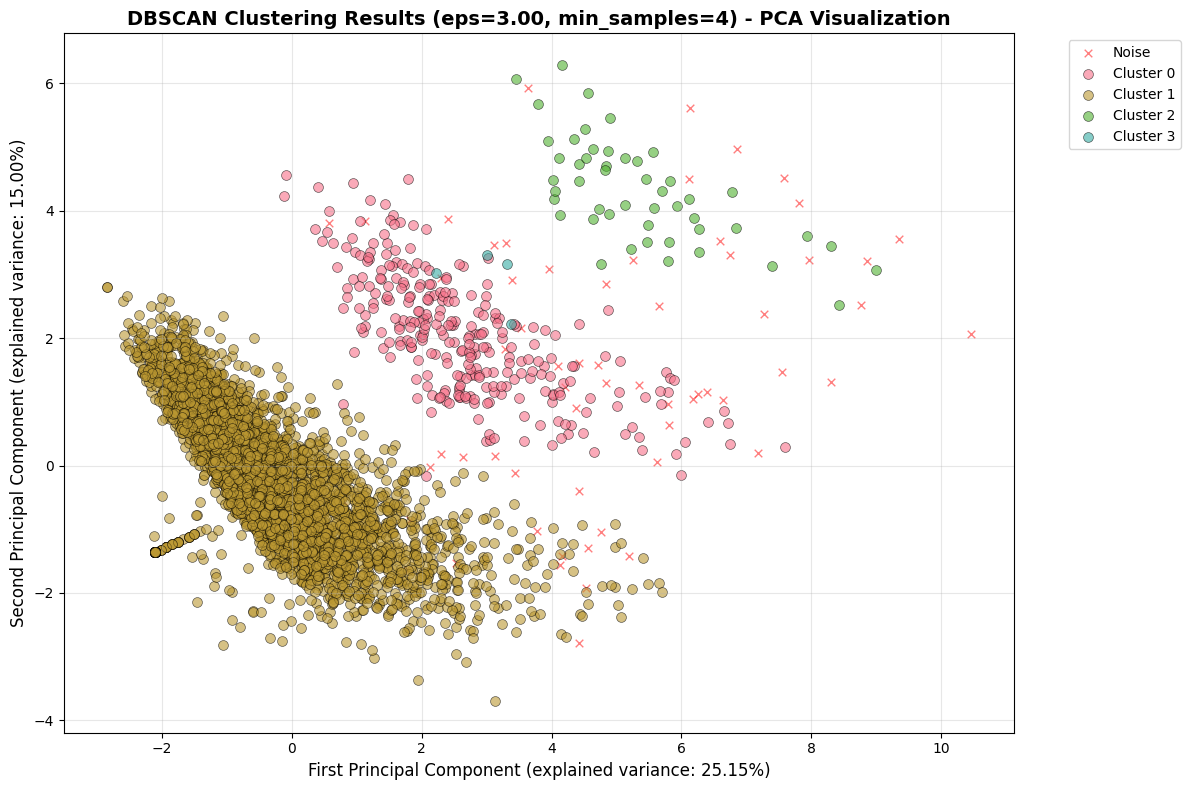

PCA explained variance ratio: [0.25148741 0.15001735]
Total explained variance: 40.15%


In [10]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot clusters
for cluster_id in sorted(df_clustered['cluster'].unique()):
    mask = cluster_labels == cluster_id
    if cluster_id == -1:
        # Noise points
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c='red', marker='x', s=30, alpha=0.5, label='Noise', linewidths=1)
    else:
        # Regular clusters
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  label=f'Cluster {cluster_id}', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'DBSCAN Clustering Results (eps={optimal_eps:.2f}, min_samples={optimal_min_samples}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plots_dir / '2.2.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")


### Evaluation Metrics


In [11]:
# Compute evaluation metrics (excluding noise points)
if len(valid_clusters) >= 2:
    non_noise_mask = cluster_labels != -1
    non_noise_labels = cluster_labels[non_noise_mask]
    non_noise_X = X_scaled[non_noise_mask]
    
    silhouette_avg = silhouette_score(non_noise_X, non_noise_labels)
    davies_bouldin = davies_bouldin_score(non_noise_X, non_noise_labels)
    calinski_harabasz = calinski_harabasz_score(non_noise_X, non_noise_labels)
    
    print("="*80)
    print("DBSCAN CLUSTERING EVALUATION METRICS")
    print("="*80)
    print(f"Parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {n_noise} ({noise_ratio:.1%})")
    print(f"\nSilhouette Score: {silhouette_avg:.4f} (excluding noise)")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f} (excluding noise)")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f} (excluding noise)")
else:
    print("Not enough clusters for evaluation metrics (need at least 2 clusters)")


DBSCAN CLUSTERING EVALUATION METRICS
Parameters: eps=3.00, min_samples=4
Number of clusters: 4
Noise points: 63 (1.4%)

Silhouette Score: 0.4037 (excluding noise)
Davies-Bouldin Score: 1.3629 (excluding noise)
Calinski-Harabasz Score: 312.0221 (excluding noise)


## Summary and Conclusions

### Key Findings:
1. **Optimal Parameters**: Selected eps and min_samples based on k-distance graph and grid search
2. **Cluster Characteristics**: Each cluster shows distinct density-based patterns
3. **Noise Points**: Identified outliers that don't belong to any dense cluster
4. **Evaluation**: Clustering quality assessed using standard metrics

### Advantages of DBSCAN:
- Can identify clusters of arbitrary shape
- Automatically determines number of clusters
- Identifies noise/outlier points
- Robust to outliers

### Next Steps:
- Compare with K-means and hierarchical clustering
- Perform final evaluation and comparison of all methods
